# Exercise 3 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Monday, Dec 5, before 14:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 2-3. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 3`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution to the marked cells.

### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
import inspect
import os

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (which is recommended) you have to mount the drive first and create a path to your python module (or download the file from your drive).

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [3]:
from shutil import copyfile

copyfile(src = "/kaggle/input/create-function/utils.py", dst = "../working/utils.py")

from utils import *

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [4]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [9]:
from torchsummary import summary

In [4]:
# TODO define device
#grab_data()
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB
2 CPUs available


In [5]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders

trainset, testset, dataset_mean, dataset_std = grab_data('data', num_cpus=1)
trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size=batch_size, num_cpus=1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [6]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

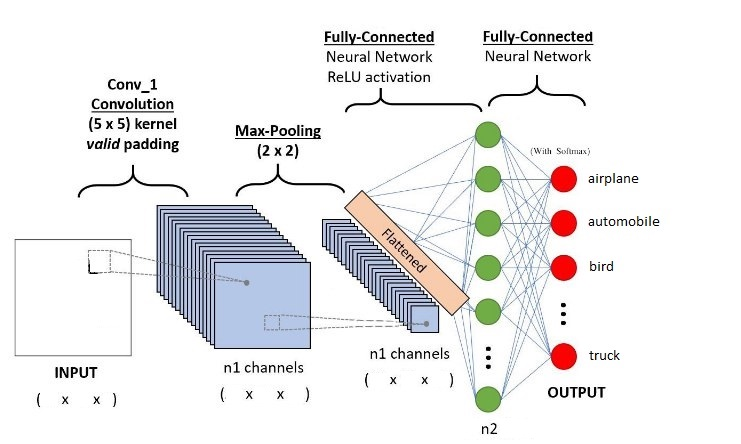

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What is the value for n2 (in_features)?
- What is the number of parameters for conv_1?

**Your answers here**

- 32 x 32 x 3
- 28 x 28 x 32
- 14 x 14 x 32
- 512(output), `14*14*32 -input`
- 5 x 5 x 3 x 32+ 32(1 bias term per output channel) = 2432

In [7]:
from torch.nn.modules.flatten import Flatten
# TODO define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        modules = [nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride = 1), # 28 * 28 * 32
                   nn.MaxPool2d(kernel_size=2), # 14 * 14 * 32
                   # default stride = kernel_size
                   nn.ReLU(),
                   nn.Flatten(),
                   nn.Linear(14*14*32, 512),
                   nn.ReLU(),
                   nn.Linear(512, 10)]
        self.model = torch.nn.Sequential(*modules)
    
    def forward(self, x):
        return self.model(x)

In [17]:
summary(CNN())

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,432
|    └─MaxPool2d: 2-2                    --
|    └─ReLU: 2-3                         --
|    └─Flatten: 2-4                      --
|    └─Linear: 2-5                       3,211,776
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       5,130
Total params: 3,219,338
Trainable params: 3,219,338
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,432
|    └─MaxPool2d: 2-2                    --
|    └─ReLU: 2-3                         --
|    └─Flatten: 2-4                      --
|    └─Linear: 2-5                       3,211,776
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       5,130
Total params: 3,219,338
Trainable params: 3,219,338
Non-trainable params: 0

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

Finished training after 167 seconds.


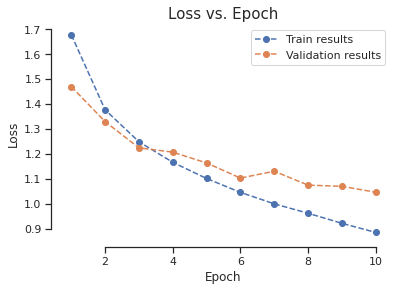

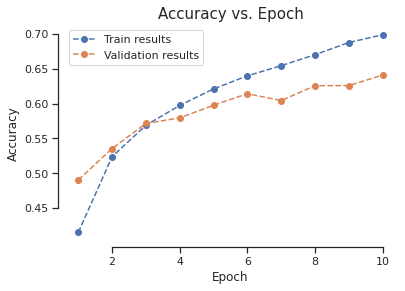

In [12]:
# TODO train and plot

lr = 0.0001
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)
model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, 10, trainloader, valloader)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)

#### **TODO**
Compare results to MLP. What can you observe?

**Your answers here**

At the same epoch, CNN gets a higher accuracy and lower loss than MLP.

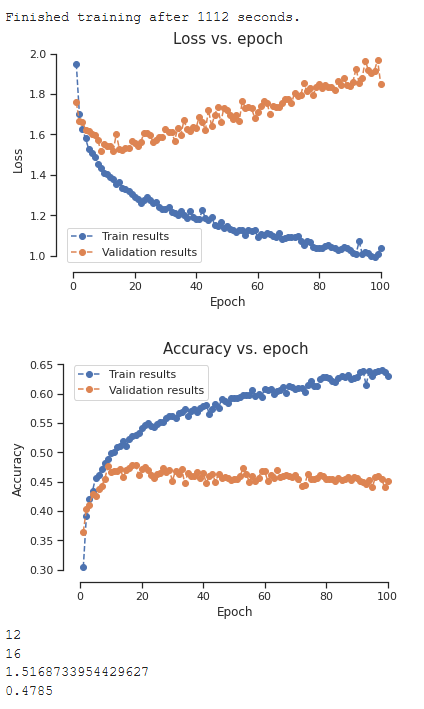

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 967 seconds.


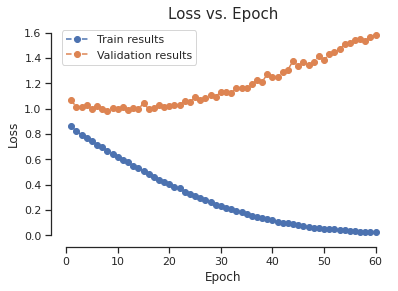

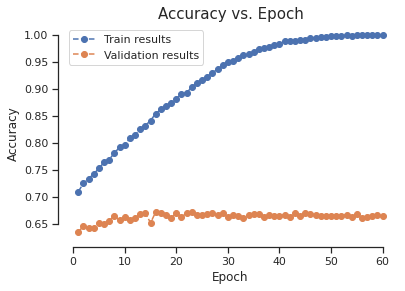

In [13]:
# TODO train and plot

epochs = 60
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)
model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**
- Validation loss is increasing but accuracy is not closer to training set; on the other hand training set is fitting almost accurately, then by assumption it seems it's overfitting. 
- Build the model deeper or more complex could be a possible solution

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

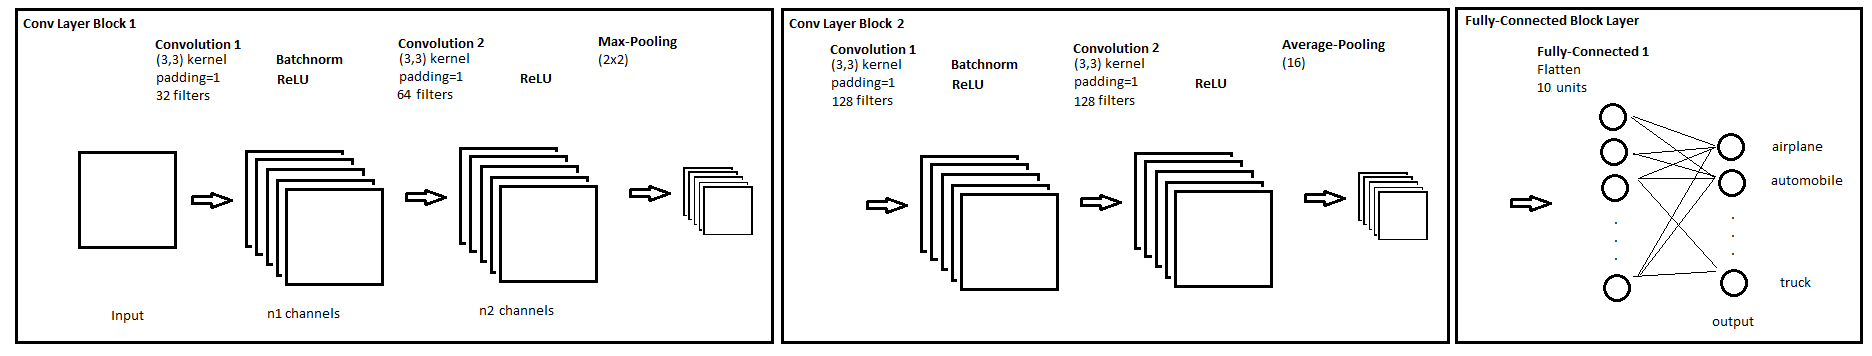

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**

- It adds rows and columes to the image before computing the network. There are 2 variants exists(pytorch),- `Valid` , `Same/Zero`.  , 'Valid' simply means no padding and 'Same' means adding all zero pixels in order to keep the same size as the input after the convolution. 
    - `valid`: feature map shrink by k-1 after each convolution with k*k kernel
    - `same`: input and feature maps have same sizes (width)
- It means it will add extra one pixel to all side of the image before the operation, together with 3 x 3 kernel the output will remain the same size as the input.
- 32 x 32 x 32 `(M = N +2P -k +1 = 32 + 2 - 3 +1 = 32)`
- 32 x 32 x 64 
-  $1+\sum_{l=1}^L (k_l-1)= 1 + 2\cdot(3-1) = 5$, $L$ -> number of conv layers
-  `in_features` -> 128
- Total Params = $(3 * 3 )* 3 * 32 + 32 (bias)    +     32 * (3 * 3) * 64 + 64 (bias) = 896 + 18496 = 19392$ + $64 (Batchnorm=32*2)$ = $19456$

In [18]:
#TODO define model 2

class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        modules = [nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                   nn.BatchNorm2d(32),
                   nn.ReLU(),
                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2),

                   nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                   nn.BatchNorm2d(128),
                   nn.ReLU(),
                   nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.AvgPool2d(kernel_size=16),

                   nn.Flatten(),
                   nn.Linear(128, 10),
                   nn.Linear(10, 10)
                  ]
        self.model = torch.nn.Sequential(*modules)
    
    def forward(self, x):
        return self.model(x)

In [20]:
summary(CNN2())

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       896
|    └─BatchNorm2d: 2-2                  64
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       18,496
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─ReLU: 2-11                        --
|    └─AvgPool2d: 2-12                   --
|    └─Flatten: 2-13                     --
|    └─Linear: 2-14                      1,290
|    └─Linear: 2-15                      110
Total params: 242,552
Trainable params: 242,552
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       896
|    └─BatchNorm2d: 2-2                  64
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       18,496
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─ReLU: 2-11                        --
|    └─AvgPool2d: 2-12                   --
|    └─Flatten: 2-13                     --
|    └─Linear: 2-14                      1,290
|    └─Linear: 2-15                      110
Total params: 242,552
Trainable params: 242,552
Non-trainable params: 0

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

#### **Answers** 

- The trend for the change of loss & accuracy on validation set follows the trend on training set better than the 1-layer CNN.
- The new model is better for finding the real pattern and generalize on the validation set, no overfitting.

Finished training after 541 seconds.


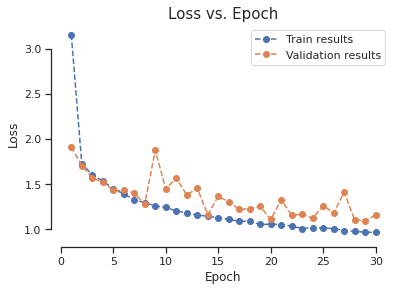

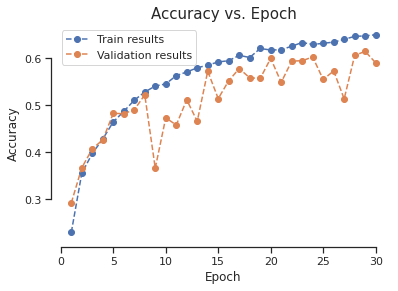

In [16]:
# TODO train and plot

lr = 0.1
epochs = 30
model = CNN2()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)
model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

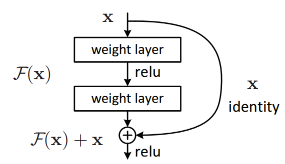

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**
-  Vanishing gradient problem.
- We would like to learn the function $H$, Then let the Residual is $R(x)$ = $H(x)$ - $x$ ,  =>$H(x)$ = $R(x)$ + $x$ . Here, residual block is overall trying to learn the true       output, $H(x)$. Here identity connection coming from $x$, the layers are actually trying to learn the residue, $R(x)$, which is the difference, hence it is called Residual.  
- By using the residual block architecure we can create more deeper networks without worrying about vanishing gradients and degradtion problem

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

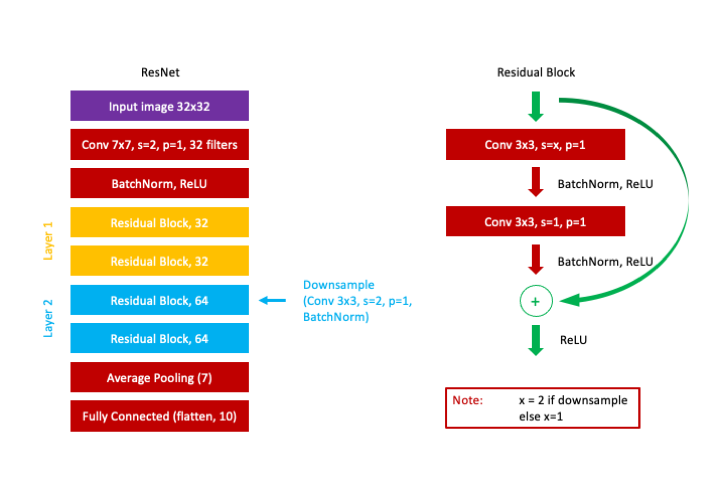

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [25]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, num_channels):
        super(ResidualBlock, self).__init__()
        
        self.input = input_channels
        self.num = num_channels
        
        if input_channels != num_channels:
            strides = 2
            self.identity = nn.Conv2d(input_channels, num_channels, 1, stride=strides)
        else:
            strides = 1
        
        modules = [nn.Conv2d(input_channels, num_channels, 3, stride=strides, padding=1),
                   nn.BatchNorm2d(num_channels),
                   nn.ReLU(),

                   nn.Conv2d(num_channels, num_channels, 3, stride=1, padding=1),
                   nn.BatchNorm2d(num_channels),
                  ]
        
        self.model = torch.nn.Sequential(*modules)

    
    def forward(self, x):
        if self.input != self.num:
            y = self.identity(x)
        else:
            y = x

        x = y + self.model(x)
        x = nn.functional.relu(x)
        return x

x = torch.rand(1, 32, 14, 14)
rb = ResidualBlock(32, 64)
rb.forward(x).size()

torch.Size([1, 64, 7, 7])

In [26]:
# TODO write a class ResNet(nn.Module) where you define the model

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        modules = [nn.Conv2d(3, 32, 7, stride=2, padding=1),
                   nn.BatchNorm2d(32),
                   nn.ReLU(),

                   ResidualBlock(32, 32),
                   ResidualBlock(32, 32),

                   ResidualBlock(32, 64),
                   ResidualBlock(64, 64),

                   nn.AvgPool2d(7),

                   nn.Flatten(),
                   nn.Linear(64, 10)
                  ]


        self.model = torch.nn.Sequential(*modules)
    
    
    def forward(self, x):
        return self.model(x)

In [19]:
# Check the dimension

x = torch.rand(1, 3, 32, 32)
rb = ResNet().model
for layer in rb:
    x = layer(x)
    print(layer.__class__.__name__,'output shape:\t\t', x.shape)

Conv2d output shape:		 torch.Size([1, 32, 14, 14])
BatchNorm2d output shape:		 torch.Size([1, 32, 14, 14])
ReLU output shape:		 torch.Size([1, 32, 14, 14])
ResidualBlock output shape:		 torch.Size([1, 32, 14, 14])
ResidualBlock output shape:		 torch.Size([1, 32, 14, 14])
ResidualBlock output shape:		 torch.Size([1, 64, 7, 7])
ResidualBlock output shape:		 torch.Size([1, 64, 7, 7])
AvgPool2d output shape:		 torch.Size([1, 64, 1, 1])
Flatten output shape:		 torch.Size([1, 64])
Linear output shape:		 torch.Size([1, 10])


In [20]:
# TODO train ResNet, using the architecture laid out in the comments and figures above


model = ResNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)
model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, 30, trainloader, valloader, early_stopper=None)

Finished training after 530 seconds.


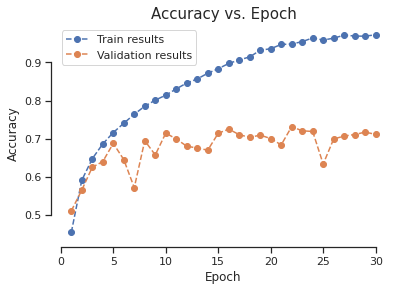

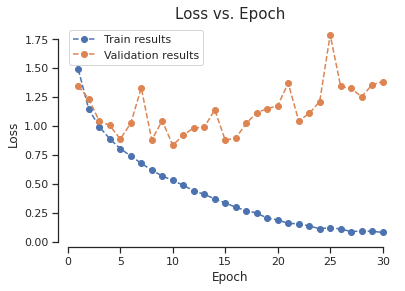

In [21]:
# TODO plot loss and accuracy for training and validation set
plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**
- Yes, ResNet has a higher accuracy and lower loss.  `ResNet` is much better than using network named- `CNN2`. Here, `ResNet` has increased the convolutional layers and with less operations, while having parameters as many `CNN2`.
- They have almost same running time, where `ResNet` a liitle bit faster.

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

-  Learning rate will be multiplyed by `gamma` after each `step_size` epoch.
- The learning rate is decreasing so fast that the model is not "learning" after the $2^{nd}$ epoch.

- Learning rate will be multiplyed by `gamma` after each `step_size` epoch.
- The learning rate decreases slowly, so the model is "learning" better.
    
- We could take  small `step_size` with a large `gamma`  (or the converse of this) which will tend to low decreasing rate and Model will learn. Otherwise, Model will not learn at all.

In [27]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader,scheduler, isReduceLROnPlateau = False, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    a = 0
    for epoch in master_bar:
        a += 1
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        if a < 6:
            print("the lr for the %d th epoch：%f" % (epoch+1, optimizer.param_groups[0]['lr']))
        
        if not isReduceLROnPlateau:
            scheduler.step()
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        if isReduceLROnPlateau:
            scheduler.step(epoch_val_loss)
            
        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            ####################
            ## YOUR CODE HERE ##
            ####################
            raise NotImplementedError # Comment out this keyword after your implementation
            
            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix



In [23]:
# TODO train and plot with step size 1, gamma 0.1

model = ResNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
model.to(device)
model.train()
train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, 10, trainloader, valloader, scheduler=scheduler, early_stopper=None)

the lr for the 1 th epoch：0.100000
the lr for the 2 th epoch：0.010000
the lr for the 3 th epoch：0.001000
the lr for the 4 th epoch：0.000100
the lr for the 5 th epoch：0.000010
Finished training after 172 seconds.


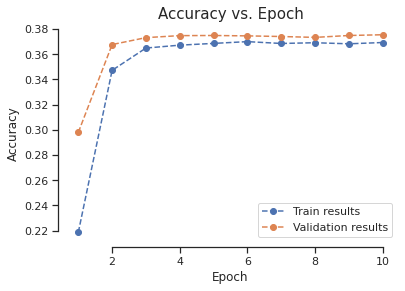

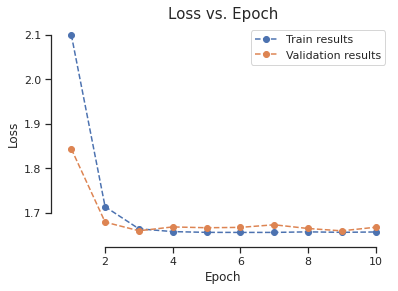

In [19]:
plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)

the lr for the 1 th epoch：0.100000

the lr for the 2 th epoch：0.090000

the lr for the 3 th epoch：0.081000

the lr for the 4 th epoch：0.072900

the lr for the 5 th epoch：0.065610

Finished training after 144 seconds.


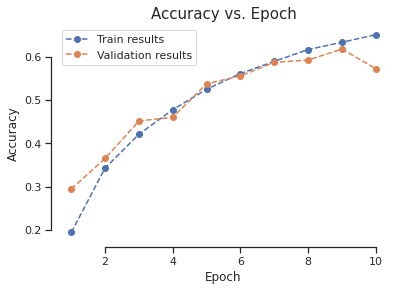

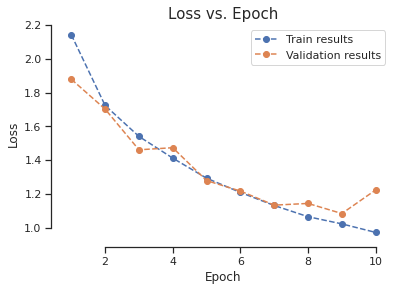

In [20]:
# TODO train and plot with step size 1, gamma 0.9

model = ResNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
model.to(device)
model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, 10, trainloader, valloader, scheduler=scheduler, early_stopper=None)

plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)

#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

1. Yes, Absolutely
2.   By using `step size=15` & `gamma = .1` , the validation accuracy "jumps" from 60% -> 70% and train accuracy also increases drastically!!

the lr for the 1 th epoch：0.100000
the lr for the 2 th epoch：0.100000
the lr for the 3 th epoch：0.100000
the lr for the 4 th epoch：0.100000
the lr for the 5 th epoch：0.100000
Finished training after 487 seconds.


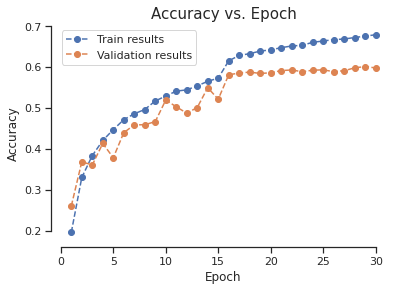

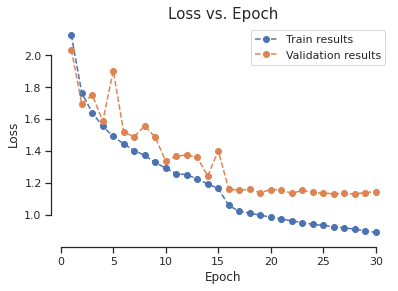

Best Results: 
val acc = 0.6014, val loss = 1.138161799311638
train acc = 0.67575, train loss = 0.8979947213913985


In [20]:
# TODO train and plot with step size 15, gamma 0.1, 30 epochs.
model = ResNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
model.to(device)
model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, 30, trainloader, valloader, scheduler=scheduler, early_stopper=None)

plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)

bestValAcc = max(val_accs)
bestEpoch = val_accs.index(bestValAcc)

print("Best Results: ")
print(f"val acc = {val_accs[bestEpoch]}, val loss = {val_losses[bestEpoch]}")
print(f"train acc = {train_accs[bestEpoch]}, train loss = {train_losses[bestEpoch]}")

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

* Using a scheduler improved the accuracy
* The ExponentialLR scheduler performed worse compared to StepLR, however, the ReduceLROnPlateau performed better compared to StepLR

the lr for the 1 th epoch：0.100000
the lr for the 2 th epoch：0.010000
the lr for the 3 th epoch：0.001000
the lr for the 4 th epoch：0.000100
the lr for the 5 th epoch：0.000010
Finished training after 465 seconds.


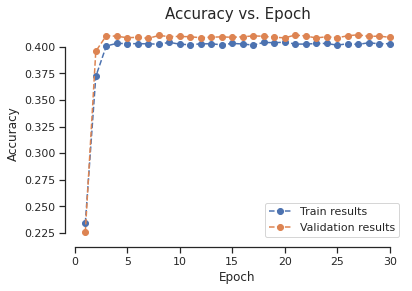

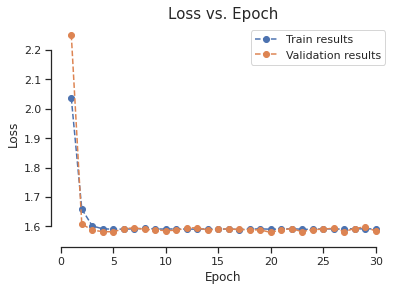

Best Results: 
val acc = 0.4113, val loss = 1.5822441518306731
train acc = 0.40215, train loss = 1.5903735768263507


In [28]:
# TODO train and plot
model = ResNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1)
model.to(device)
model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, 30, trainloader, valloader, scheduler=scheduler, early_stopper=None)

plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)

bestValAcc = max(val_accs)
bestEpoch = val_accs.index(bestValAcc)

print("Best Results: ")
print(f"val acc = {val_accs[bestEpoch]}, val loss = {val_losses[bestEpoch]}")
print(f"train acc = {train_accs[bestEpoch]}, train loss = {train_losses[bestEpoch]}")

the lr for the 1 th epoch：0.100000
the lr for the 2 th epoch：0.100000
the lr for the 3 th epoch：0.100000
the lr for the 4 th epoch：0.100000
the lr for the 5 th epoch：0.100000
Finished training after 494 seconds.


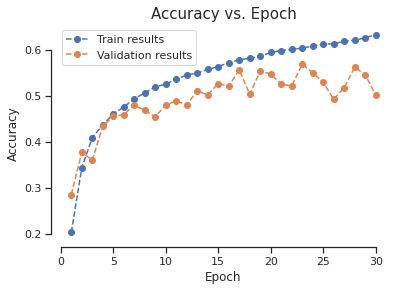

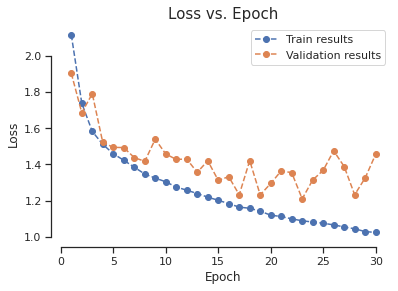

Best Results: 
val acc = 0.5689, val loss = 1.2093570172786712
train acc = 0.60415, train loss = 1.0878630193175785


In [58]:
# TODO train and plot
model = ResNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10)
model.to(device)
model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, 30, trainloader, valloader, scheduler=scheduler, isReduceLROnPlateau = True, early_stopper=None)

plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)

bestValAcc = max(val_accs)
bestEpoch = val_accs.index(bestValAcc)

print("Best Results: ")
print(f"val acc = {val_accs[bestEpoch]}, val loss = {val_losses[bestEpoch]}")
print(f"train acc = {train_accs[bestEpoch]}, train loss = {train_losses[bestEpoch]}")

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

* In the fine-tune phase the performance is worse than the previous restnet model used in the excersize.
* As all the layers in the pre-trained resnet model is frozen, we only need to train the final fc layer. So, the training is faster compared to the previous resnet.

* After fine-tuning the final fc layer, the layers in the pre-trained was unfreezed and the model was trained for 30 epoch, the performance after this 30 epoch is the best so far.

In [9]:
# TODO do transfer learning with resnet on cifar10

pretrained_model = models.resnet18(pretrained = True).to(device)
    
for param in pretrained_model.parameters():
    param.requires_grad = False
    
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 10).to(device)

for param in pretrained_model.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

the lr for the 1 th epoch：0.100000
the lr for the 2 th epoch：0.100000
the lr for the 3 th epoch：0.100000
the lr for the 4 th epoch：0.100000
the lr for the 5 th epoch：0.100000
Finished training after 1697 seconds.


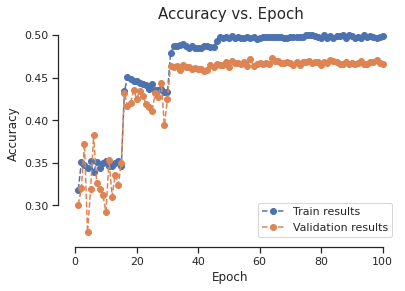

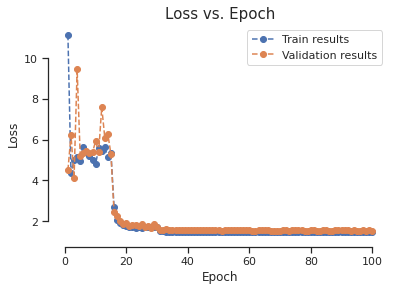

Best Results: 
val acc = 0.4725, val loss = 1.546450075507164
train acc = 0.498125, train loss = 1.4524377440191378


In [12]:
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
pretrained_model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(pretrained_model, optimizer, loss_function, device, 100, trainloader, valloader, scheduler=scheduler, early_stopper=None)

plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)

bestValAcc = max(val_accs)
bestEpoch = val_accs.index(bestValAcc)

print("Best Results: ")
print(f"val acc = {val_accs[bestEpoch]}, val loss = {val_losses[bestEpoch]}")
print(f"train acc = {train_accs[bestEpoch]}, train loss = {train_losses[bestEpoch]}")


In [13]:
# Unfreezing the restnet layers
for param in pretrained_model.parameters():
    param.requires_grad = True

the lr for the 1 th epoch：0.001000
the lr for the 2 th epoch：0.001000
the lr for the 3 th epoch：0.001000
the lr for the 4 th epoch：0.001000
the lr for the 5 th epoch：0.001000
Finished training after 588 seconds.


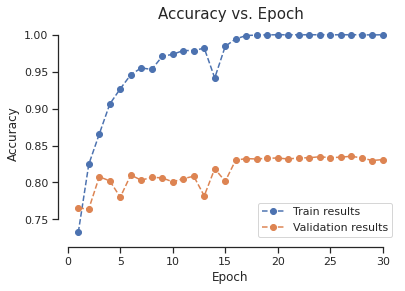

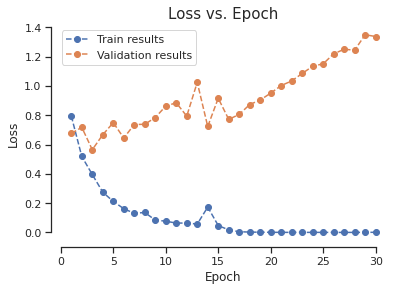

Best Results: 
val acc = 0.8354, val loss = 1.2506605610251427
train acc = 0.999925, train loss = 0.0003682290237630713


In [15]:
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma = 0.1)
pretrained_model.train()
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(pretrained_model, optimizer, loss_function, device, 30, trainloader, valloader, scheduler=scheduler, early_stopper=None)

plot('Accuracy vs. Epoch', 'Accuracy' ,train_accs, val_accs)
plot('Loss vs. Epoch', 'Loss' ,train_losses, val_losses)

bestValAcc = max(val_accs)
bestEpoch = val_accs.index(bestValAcc)

print("Best Results: ")
print(f"val acc = {val_accs[bestEpoch]}, val loss = {val_losses[bestEpoch]}")
print(f"train acc = {train_accs[bestEpoch]}, train loss = {train_losses[bestEpoch]}")
